In [1]:
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/data/dari-pasentran-ke-istana.gz
# !tar -xf dari-pasentran-ke-istana.gz

In [2]:
import librosa
import pyworld as pw
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

In [3]:
# !pip3 install malaya-gpu -U --no-deps

In [4]:
import yaml

with open('config.yaml') as fopen:
    config = yaml.load(fopen)
    
config

/home/husein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


{'sampling_rate': 22050,
 'fft_size': 1024,
 'hop_size': 256,
 'win_length': None,
 'window': 'hann',
 'num_mels': 80,
 'fmin': 80,
 'fmax': 7600,
 'global_gain_scale': 1.0,
 'trim_silence': True,
 'trim_threshold_in_db': 20,
 'trim_frame_size': 2048,
 'trim_hop_size': 512}

In [5]:
import numpy as np

# https://github.com/TensorSpeech/TensorFlowTTS/blob/master/tensorflow_tts/utils/outliers.py
def is_outlier(x, p25, p75):
    """Check if value is an outlier."""
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return x <= lower or x >= upper


def remove_outlier(x, p_bottom: int = 25, p_top: int = 75):
    """Remove outlier from x."""
    p_bottom = np.percentile(x, p_bottom)
    p_top = np.percentile(x, p_top)

    indices_of_outliers = []
    for ind, value in enumerate(x):
        if is_outlier(value, p_bottom, p_top):
            indices_of_outliers.append(ind)

    x[indices_of_outliers] = 0.0
    x[indices_of_outliers] = np.max(x)
    return x

In [6]:
import re

_pad = "pad"
_eos = "eos"
_punctuation = "!'(),.:;? "
_special = "-"
_letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

# Export all symbols:
MALAYA_SPEECH_SYMBOLS = (
    [_pad] + list(_special) + list(_punctuation) + list(_letters) + [_eos]
)

# Regular expression matching text enclosed in curly braces:
_curly_re = re.compile(r"(.*?)\{(.+?)\}(.*)")

In [7]:
def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

In [8]:
from unidecode import unidecode
import malaya

normalizer = malaya.normalize.normalizer(date = False, time = False)

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, normalize = True, add_eos = True):
    sequence = []
    string = convert_to_ascii(string)
    string = string.replace('&', ' dan ')
    string = put_spacing_num(string)
    if normalize:
        string = normalizer.normalize(string, 
                                      check_english = False, 
                                      normalize_entity = False, 
                                      normalize_text = False,
                                      normalize_url = True,
                                      normalize_email = True)
        string = string['normalize']
    else:
        string = string
    string = string.lower()
    return string, tts_encode(string, add_eos = add_eos)

In [9]:
from glob import glob
from tqdm import tqdm

txts = glob('../youtube/malay/*istana/*istana*/*.txt')
txts.extend(glob('../youtube/malay2/*turki/*turki*/*.txt'))
txts.extend(glob('../youtube/malay2/*turki-short/*turki*/*.txt'))
txts.extend(glob('../youtube/malay/*istana-short/*istana*/*.txt'))
len(txts)

38267

In [10]:
import malaya_speech
from malaya_speech import Pipeline
vad = malaya_speech.vad.webrtc()

def process(txts, silent_trail = 500):
    txts = txts[0]
    audios, mels, text_ids, f0s, energies = [], [], [], [], []

    for f in tqdm(txts):
        with open(f) as fopen:
            text = fopen.read()
        if re.match('^.*(RM|rm)[0-9]+.*$', text):
            continue
        text = cleaning(text)
        r = f.replace('output-text', 'output-wav').replace('.txt', '')

        audio, _ = malaya_speech.load(r, sr = config['sampling_rate'])

        if (len(audio) / config['sampling_rate']) > 25:
            print('skipped, audio too long')
            continue

        if config['trim_silence']:
            y_= malaya_speech.resample(audio, config['sampling_rate'], 16000)
            y_ = malaya_speech.astype.float_to_int(y_)
            frames = list(malaya_speech.generator.frames(audio, 30, config['sampling_rate']))
            frames_ = list(malaya_speech.generator.frames(y_, 30, 16000, append_ending_trail = False))
            frames_webrtc = [(frames[no], vad(frame)) for no, frame in enumerate(frames_)]
            grouped_deep = malaya_speech.group.group_frames(frames_webrtc)
            grouped_deep = malaya_speech.group.group_frames_threshold(grouped_deep, 0.1)
            r = []
            for g in grouped_deep:
                if g[1]:
                    g = g[0].array
                else:
                    g = np.concatenate([g[0].array[:silent_trail], g[0].array[-silent_trail:]])
                r.append(g)
            audio = np.concatenate(r)

        D = librosa.stft(
            audio,
            n_fft=config['fft_size'],
            hop_length=config['hop_size'],
            win_length=config['win_length'],
            window=config['window'],
            pad_mode='reflect',
        )
        S, _ = librosa.magphase(D) 
        fmin = 0 if config["fmin"] is None else config["fmin"]
        fmax = sampling_rate // 2 if config["fmax"] is None else config["fmax"]
        mel_basis = librosa.filters.mel(
            sr=config['sampling_rate'],
            n_fft=config["fft_size"],
            n_mels=config["num_mels"],
            fmin=fmin,
            fmax=fmax,
        )
        mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
        audio = np.pad(audio, (0, config["fft_size"]), mode="edge")
        audio = audio[: len(mel) * config['hop_size']]

        _f0, t = pw.dio(
            audio.astype(np.double),
            fs=config['sampling_rate'],
            f0_ceil=fmax,
            frame_period=1000 * config['hop_size'] / config['sampling_rate'],
        )
        f0 = pw.stonemask(audio.astype(np.double), _f0, t, config['sampling_rate'])
        if len(f0) >= len(mel):
            f0 = f0[: len(mel)]
        else:
            f0 = np.pad(f0, (0, len(mel) - len(f0)))

        # extract energy
        energy = np.sqrt(np.sum(S ** 2, axis=0))
        f0 = remove_outlier(f0)
        energy = remove_outlier(energy)

        if config["global_gain_scale"] > 0.0:
            audio *= config["global_gain_scale"]

        if len(energy[energy != 0]) == 0 or len(f0[f0 != 0]) == 0:
            print('skipped')
            continue

        audios.append(audio)
        mels.append(mel)
        text_ids.append(text)
        f0s.append(f0)
        energies.append(energy)
    
    return [[audios, mels, text_ids, f0s, energies]]

In [11]:
import matplotlib.pyplot as plt
import IPython.display as ipd

In [12]:
i = 11
r = process((txts[i: i + 5],))[0]

100%|██████████| 5/5 [00:01<00:00,  3.68it/s]


In [13]:
ipd.Audio(r[0][3], rate = 22050)

In [14]:
r[2][2][0]

'dan banyak rakan lain lagi dibikin tidak jemu - jemu memberi dorongan di luar lingkungan universiti'

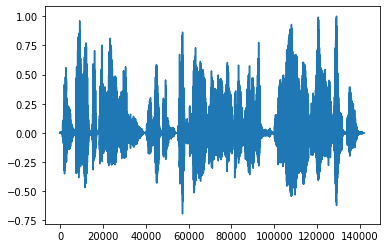

In [15]:
plt.plot(r[0][2])

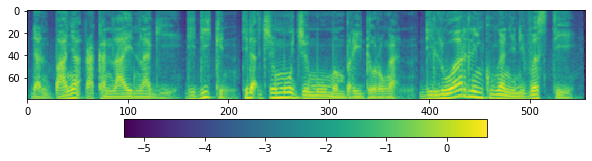

In [16]:
mel_outputs_ = np.reshape(r[1][2], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [17]:
import mp

audios, mels, text_ids, f0s, energies = [], [], [], [], []

In [18]:
for i in range(0, len(txts), 1000):
    index = min(i + 1000, len(txts))
    b = txts[i: index]
    results = mp.multiprocessing(b, process, cores = 10, returned = True)
    for result in results:
        audios.extend(result[0])
        mels.extend(result[1])
        text_ids.extend(result[2])
        f0s.extend(result[3])
        energies.extend(result[4])

 39%|███▉      | 39/100 [00:25<00:50,  1.21it/s]

skipped, audio too long


 83%|████████▎ | 83/100 [00:59<00:06,  2.50it/s]

skipped, audio too long


 93%|█████████▎| 93/100 [01:06<00:03,  1.75it/s]

skipped, audio too long


  6%|▌         | 6/100 [00:03<00:54,  1.73it/s]

skipped, audio too long


 21%|██        | 21/100 [00:13<00:42,  1.88it/s]

skipped, audio too long


 67%|██████▋   | 67/100 [00:45<00:19,  1.71it/s]

skipped, audio too long


 73%|███████▎  | 73/100 [00:47<00:19,  1.36it/s]

skipped, audio too long


 65%|██████▌   | 65/100 [00:52<00:21,  1.62it/s]

skipped, audio too long


 70%|███████   | 70/100 [00:50<00:18,  1.58it/s]

skipped, audio too long


 92%|█████████▏| 92/100 [01:03<00:05,  1.43it/s]

skipped, audio too long


 24%|██▍       | 24/100 [00:08<00:19,  3.89it/s]

skipped


 23%|██▎       | 23/100 [00:06<00:20,  3.72it/s]

skipped


 25%|██▌       | 25/100 [00:07<00:28,  2.68it/s]

skipped


 25%|██▌       | 25/100 [00:07<00:19,  3.81it/s]

skipped


 55%|█████▌    | 55/100 [00:16<00:14,  3.19it/s]

skipped


 22%|██▏       | 22/100 [00:06<00:22,  3.52it/s]

skipped


 25%|██▌       | 25/100 [00:07<00:23,  3.19it/s]

skipped


 55%|█████▌    | 55/100 [00:16<00:11,  3.80it/s]

skipped


 95%|█████████▌| 95/100 [00:30<00:00,  5.18it/s]

skipped


 94%|█████████▍| 94/100 [00:20<00:01,  5.14it/s]

skipped


 41%|████      | 41/100 [00:09<00:16,  3.60it/s]

skipped


 63%|██████▎   | 63/100 [00:12<00:06,  5.52it/s]

skipped


  3%|▎         | 3/100 [00:00<00:32,  2.96it/s]

skipped


 20%|██        | 20/100 [00:04<00:23,  3.43it/s]

skipped


 26%|██▌       | 26/100 [00:06<00:17,  4.15it/s]

skipped


 70%|███████   | 70/100 [00:16<00:06,  4.68it/s]

skipped


 76%|███████▌  | 76/100 [00:17<00:04,  5.08it/s]

skipped


 32%|███▏      | 32/100 [00:07<00:13,  5.14it/s]

skipped


 29%|██▉       | 29/100 [00:06<00:15,  4.46it/s]

skipped


 42%|████▏     | 42/100 [00:08<00:12,  4.76it/s]

skipped


 50%|█████     | 50/100 [00:11<00:10,  4.74it/s]

skipped


  8%|▊         | 8/100 [00:02<00:22,  4.01it/s]]

skipped


 32%|███▏      | 32/100 [00:08<00:16,  4.07it/s]

skipped


 39%|███▉      | 39/100 [00:09<00:13,  4.59it/s]

skipped


 68%|██████▊   | 68/100 [00:16<00:08,  3.83it/s]

skipped


 10%|█         | 10/100 [00:02<00:20,  4.48it/s]

skipped


 90%|█████████ | 90/100 [00:22<00:02,  4.52it/s]

skipped


  5%|▌         | 5/100 [00:01<00:23,  4.04it/s]

skipped


  6%|▌         | 6/100 [00:02<00:34,  2.70it/s]]

skipped


 15%|█▌        | 15/100 [00:04<00:33,  2.53it/s]

skipped


 68%|██████▊   | 68/100 [00:16<00:08,  3.72it/s]

skipped


 66%|██████▌   | 66/100 [00:14<00:07,  4.78it/s]

skipped


 35%|███▌      | 35/100 [00:08<00:11,  5.66it/s]

skipped


 74%|███████▍  | 74/100 [00:16<00:03,  6.60it/s]

skipped


  1%|          | 1/100 [00:00<00:10,  9.78it/s]

skipped


 14%|█▍        | 14/100 [00:03<00:23,  3.72it/s]

skipped


100%|██████████| 26/26 [00:06<00:00,  3.86it/s]


In [19]:
scaler_mel = StandardScaler(copy=False)
scaler_energy = StandardScaler(copy=False)
scaler_f0 = StandardScaler(copy=False)

for mel, f0, energy in zip(mels, f0s, energies):

    scaler_mel.partial_fit(mel)
    scaler_energy.partial_fit(energy[energy != 0].reshape(-1, 1))
    scaler_f0.partial_fit(f0[f0 != 0].reshape(-1, 1))

In [20]:
for i in tqdm(range(len(mels))):
    mels[i] = scaler_mel.transform(mels[i])

100%|██████████| 38217/38217 [00:10<00:00, 3529.41it/s]


In [21]:
def save_statistics_to_file(scaler_list, config):
    os.system('mkdir male-stats')
    for scaler, name in scaler_list:
        stats = np.stack((scaler.mean_, scaler.scale_))
        np.save(
            os.path.join(f"male-stats/stats{name}.npy"),
            stats.astype(np.float32),
            allow_pickle=False,
        )

In [22]:
scaler_list = [(scaler_mel, ""), (scaler_energy, "_energy"), (scaler_f0, "_f0")]
save_statistics_to_file(scaler_list, config)

In [23]:
!rm -rf output-male-v2

In [24]:
os.system('mkdir output-male-v2')
directories = ['audios', 'mels', 'text_ids', 'f0s', 'energies']
for d in directories:
    os.system(f'mkdir output-male-v2/{d}')

In [25]:
for i in tqdm(range(len(mels))):
    np.save(f'output-male-v2/audios/{i}.npy', audios[i])
    np.save(f'output-male-v2/mels/{i}.npy', mels[i])
    np.save(f'output-male-v2/text_ids/{i}.npy', text_ids[i])
    np.save(f'output-male-v2/f0s/{i}.npy', f0s[i])
    np.save(f'output-male-v2/energies/{i}.npy', energies[i])

100%|██████████| 38217/38217 [04:01<00:00, 157.99it/s]
